The notebook is used to visualize the performance of PCE

In [1]:
# import packages
import pandas as pd
import numpy as np
import pickle
from veneer.pest_runtime import *
from veneer.manage import start,kill_all_now
import os

from funcs.read_data import variables_prep, file_settings
from funcs.modeling_funcs import vs_settings, \
        modeling_settings, paralell_vs, obtain_initials, change_param_values
from funcs.utils import timeseries_sum, update_bounds

In [2]:
# define the function for adaptive pce
vs_list = []
from run_source import run_source_lsq, run_source_annual

## import samples and results for pce-sse

In [3]:
import pickle
year = 'rmse'
num_iter = 3
pce_load = pickle.load(open(f'{file_settings()[0]}adaptive/rmse_iter{num_iter}/pce-{year}-iter{num_iter}.pkl', "rb")) #-level4

In [4]:
# import observation if the output.txt requires the use of obs.
date_range = pd.to_datetime(['2009/07/01', '2018/06/30'])
observed_din = pd.read_csv(f'{file_settings()[1]}126001A.csv', index_col='Date')
observed_din.index = pd.to_datetime(observed_din.index)
observed_din = observed_din.loc[date_range[0]:date_range[1], :].filter(items=[observed_din.columns[0]]).apply(lambda x: 1000 * x)

In [5]:
# import the validation set
vali_samples = pd.read_csv(f'{file_settings()[1]}samples.csv', index_col='real_name')
vali_values = pd.read_csv(f'{file_settings()[1]}DIN_126001A.csv', index_col = 'Unnamed: 0')
vali_values.index = pd.to_datetime(vali_values.index)

In [6]:
# calculate the summed squared residuals of annual loads
vali_annual = timeseries_sum(vali_values, temp_scale = 'annual')
obs_din = timeseries_sum(observed_din, temp_scale = 'annual')
din_126001A = pd.DataFrame(vali_annual, dtype='float')
if year =='sse':
    resid = (obs_din.values - vali_annual.values)
    sse = np.sum(resid ** 2, axis=0)
    sse = sse.reshape(sse.shape[0], 1)
elif year == 'rmse':
    resid = (obs_din.values - vali_annual.values)
    sse = (np.mean(resid ** 2, axis=0)) ** 0.5
    sse = sse.reshape(sse.shape[0], 1)
else:
    sse = din_126001A.loc[year, :].values

model_vals = sse

In [7]:
# calculate the outputs of pce
pce_vals = pce_load(vali_samples.values.T)

# extract the training samples
# train_samples = pce_load.variable_transformation.map_from_canonical_space(pce_load.samples)
# train_vals = pce_load.values

train_set = np.loadtxt(f'{file_settings()[0]}adaptive/rmse_iter{num_iter}/train_samples.txt')
train_vals = train_set[-1, :]

In [8]:
train_vals.shape

(155,)

## Scatter plot of validation samples

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc
import latex
rc("text", usetex=False)
import seaborn as sns
from sklearn import metrics

In [11]:
# calculate the error 
r2 = metrics.r2_score(model_vals.flatten()[0:1000], pce_vals.flatten()[0:1000])

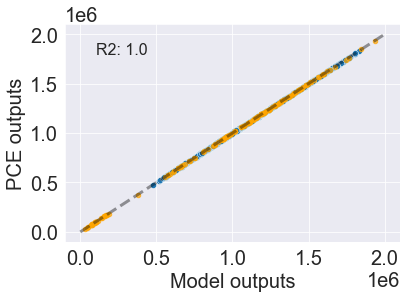

In [12]:
sns.set_style('darkgrid')
ax = sns.scatterplot(x = model_vals.flatten()[0:1000], y = pce_vals.flatten()[0:1000]);
ax.scatter(x = train_vals, y = train_vals, color='orange', alpha=0.7, s=20)
ax.set_xlabel('Model outputs')
ax.set_ylabel('PCE outputs')
ax.text(x=1e5, y=1.8e6, s=f'R2: {np.round(r2, 2)}');
# Add a 1-1 line
x_line = np.linspace(0, 2e6, 10000)
y_line = x_line
sns.lineplot(x = x_line, y = y_line, color='k', ax=ax, linestyle='--', alpha=0.4)
plt.savefig(f'{file_settings()[0]}figs/PCE_{year}_rmse_iter{num_iter}.png', format='png', dpi=300)

## Plot the residuals between the surrogate and the model

In [13]:
# calculate the residuals
resid = pce_vals.flatten() - model_vals.flatten()
bounds = [np.quantile(resid, 0.025), np.quantile(resid, 0.975)]
bounds

[-3275.5718104340253, 2933.375575691903]

In [15]:
# update the uncertainty bounds
f_name = f'{file_settings()[0]}adaptive/rmse_bounds.pkl'
bounds_dict = update_bounds(f_name, bounds)

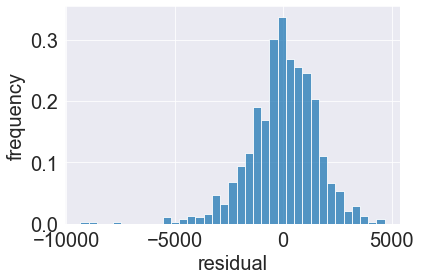

In [16]:
# plot the distribution of residuals
ax = sns.histplot(resid, stat='frequency');
ax.set_xlabel('residual')
ax.set_ylabel('frequency');
plt.savefig(f'{file_settings()[0]}figs/residual_rmse_iter{num_iter}.png', format='png', dpi=300)